In [1]:
from rdkit import Chem
import pickle
import numpy as np
import pandas as pd
from IPython.display import display
from copy import deepcopy

# Load processed data

In [2]:
dataset = pd.read_csv("/home/abhor/Desktop/datasets/my_uspto/processed_data.csv", index_col=0)

In [3]:
dataset

,reactants,reagents,products
0,CON(C)C(=O)c1ccc(O)nc1,C1CCOC1.[Cl-],CC(C)CC(=O)c1ccc(O)nc1
1,O=C(O)c1ccc(Cl)c([N+](=O)[O-])c1,O,CNc1ccc(C(=O)O)cc1[N+](=O)[O-]
2,CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(N)cc3)cc21,NaN,CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(NC=O)cc3)cc21
3,COCC(C)Oc1cc(Oc2cnc(C(=O)N3CCC3)cn2)cc(C(=O)O)c1,CC(C)=C(Cl)N(C)C.ClCCl.c1ccncc1,COCC(C)Oc1cc(Oc2cnc(C(=O)N3CCC3)cn2)cc(C(=O)Nc...
4,Clc1cc2c(Cl)nc(-c3ccncc3)nc2s1,NaN,Clc1cc2c(NCc3ccc(Cl)c(Cl)c3)nc(-c3ccncc3)nc2s1
...,...,...,...
448504,CCP(CC)CC,NaN,CCCCOS(=O)(=O)[O-]
448505,CCCCOS(=O)(=O)OCCCC,NaN,CCCC[P+](CC)(CC)CC
448506,Cc1cccc(C)c1N=C1NCCN1OCc1ccccn1,CC#N.Cl,Cc1cccc(C)c1N=C1NCCN1O
448507,Clc1ccnc(Cl)c1,ClCCl,N[n+]1ccc(Cl)cc1Cl


# Reaction signature

In [4]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import DataStructs
from rdkit.Chem import rdFMCS
from rdkit.Chem import AllChem
from rdkit.Chem import rdchem

In [5]:
# draw molecule with index
def mol_with_atom_index( mol ):
    mol = deepcopy(mol)
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol

Reactant

Signature


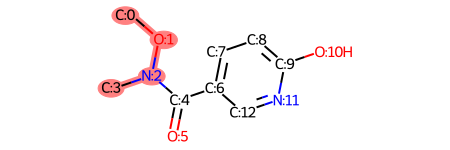

Centre at [2]
---------------------------------------------------------------------------------------------------- 
Product

Signature


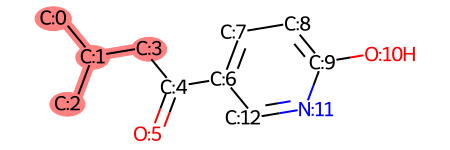

Centre at [3]
([2], [3])
('[CH3:0][O:1][NH:2][CH3:3]', '[CH3:0][CH:1]([CH3:2])[CH3:3]')


In [6]:
def highlight_atoms(mol, hit_ats):
    '''
    Highlight the atoms in mol that have index in 'hit_ats'
    '''
#     # this is the code given in rdkit docs but doesn't actually work
#     d = rdMolDraw2D.MolDraw2DSVG(500, 500) # or MolDraw2DCairo to get PNGs
#     rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=hit_ats,)
    mol.__sssAtoms = hit_ats # workaround for now. Might not work in a later version of rdkit

class RLMol:
    def __init__(self, mol):
        self.mol = mol
    
    def display_mol(self, atom_num=False, highlight=False):
        mol = Chem.MolFromSmiles(Chem.MolToSmiles(self.mol))
        if atom_num:
            mol = mol_with_atom_index(mol)
        if highlight:
            highlight_atoms(mol, self.sig)
        display(mol)
        
    def calculate_centres_and_signatures(self, common_subsequence, debug=False):
        # input
        mol = Chem.Mol(self.mol)
        cs = Chem.Mol(common_subsequence)
        
        # deal with atom indices
        mol_indices = list(range(mol.GetNumAtoms()))
        mol_indices_in_cs = np.array(rdchem.Mol(mol).GetSubstructMatch(cs))
        
        # find signature
        difference = list(set(mol_indices) - set(mol_indices_in_cs))
        self.sig = difference
        
        # find centre
        self.cen = []
        for idx in self.sig:
            atom = mol.GetAtomWithIdx(idx)
            neighbors = atom.GetNeighbors()
            neighbors_indices = list(map(lambda x: x.GetIdx(), neighbors))
            if set(neighbors_indices) - set(self.sig): # this atom has a neighbor outside of signature
                self.cen.append(idx)

        # if debug, display
        if debug:
            print("Signature")
            self.display_mol(atom_num=True, highlight=True)
            
            print("Centre at", self.cen)
    
    def get_signature(self):
        # calc Mol from list of ints
        sig = None
        mol = mol_with_atom_index(self.mol)
        with Chem.RWMol(mol) as mw:
            for idx in set(list(range(self.mol.GetNumAtoms()))) - set(self.sig):
                mw.RemoveAtom(idx)
            sig = Chem.Mol(mw)
        return mw
    
    def get_smiles_signature(self):
        return Chem.MolToSmiles(self.get_signature())
    
    def get_centre(self):
        return self.cen
                
            
        

class Reaction:
    def __init__(self, reactant, product):
        self.reactant = RLMol(reactant)
        self.product = RLMol(product)
        
    def _GetMCS(self):
        '''Get the Maximum common subsequence from reactant and product'''
        mcs = rdFMCS.FindMCS([self.reactant.mol, self.product.mol])
        return Chem.MolFromSmarts(mcs.smartsString)
    
    def display_reactant(self, atom_num=False, highlight=False):
        self.reactant.display_mol(atom_num, highlight)
            
            
    def display_product(self, atom_num=False, highlight=False):
        self.product.display_mol(atom_num, highlight)
    
    def calculate_centres_and_signatures(self, debug=False):
        '''
        Calculates centres and signatures from reactants and products
        Returns None
        '''
        mcs = self._GetMCS()
        if debug:
            print("Reactant\n")
        self.reactant.calculate_centres_and_signatures(mcs, debug)
        
        if debug:
            print("-"*100, "\nProduct\n")
        self.product.calculate_centres_and_signatures(mcs, debug)
    
    def get_signatures(self):
        # calc Mol from atom indices
        return self.reactant.get_signature(), self.product.get_signature()
    
    def get_smiles_signatures(self):
        return self.reactant.get_smiles_signature(), self.product.get_smiles_signature()
    
    def get_centres(self):
        # calc 
        return self.reactant.get_centre(), self.product.get_centre()
        

i = 0
mol1 = Chem.MolFromSmiles(dataset["reactants"][i])
mol2 = Chem.MolFromSmiles(dataset["products"][i])
R = Reaction(mol1, mol2)
R.calculate_centres_and_signatures(debug=True)
print(R.get_centres())
print(R.get_smiles_signatures())

In [ ]:
rsig_list = []
psig_list = []
rcen_list = []
pcen_list = []

for i in range(dataset.shape[0]):
    mol1 = Chem.MolFromSmiles(dataset["reactants"][i])
    mol2 = Chem.MolFromSmiles(dataset["products"][i])

    R = Reaction(mol1, mol2)
    R.calculate_centres_and_signatures()
    
    rcen, pcen = R.get_centres()
    rsig, psig = R.get_smiles_signatures()
    
    rsig_list.append(rsig)
    psig_list.append(psig)    
    rcen_list.append(rcen)    
    pcen_list.append(pcen)    
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [33]:
df = dataset.iloc[:100]

df = df.drop("reagents", axis=1)

In [36]:
df["rsig"] = rsig_list
df["psig"] = psig_list
df["rcen"] = rcen_list
df["pcen"] = pcen_list